# Forest Detection
Masks are transformed to be binary single-channel. Low contrast images are enhanced using CLAHE technique. A U-Net is constructed alongside Adam as the optimizer and Tversky loss as the loss function. Intersection over Union (IoU) is used as an indicator to validate if the model is well-trained.

We choose the parameters to be:
- learning rate: 1e-3
- drop out rate: 0.1
- alpha, beta (Tversky loss coefficients): 0.4, 0.6

The trained model has **average IoU of 0.71** which is much better than the baseline IoU 0.38.

### Imported packages and global parameters

In [1]:
import os, sys

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split, KFold

## file preprocess
DATA_DIR = './Forest_Segmented'
DATA_FILE = os.path.join(DATA_DIR, 'meta_data.csv')
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'masks')

## image preprocess
# IMAGE_SHAPE = (256, 256)
IMAGE_THRESHOLD = 127 # 90

## model params
INPUT_CHANNEL = 3
OUTPUT_CHANNEL = 1

## torch device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


## File preprocess

In [2]:
# img_files = [f for f in os.listdir(IMAGE_DIR) if os.path.isfile(os.path.join(IMAGE_DIR, f))]
# img_files[0]
for f in os.listdir(IMAGE_DIR):
    if os.path.isfile(os.path.join(IMAGE_DIR, f)):
        print(f)
        break

10452_sat_08.jpg


In [3]:
## import data from csv
df = pd.read_csv(DATA_FILE)
df.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


(256, 256, 3)


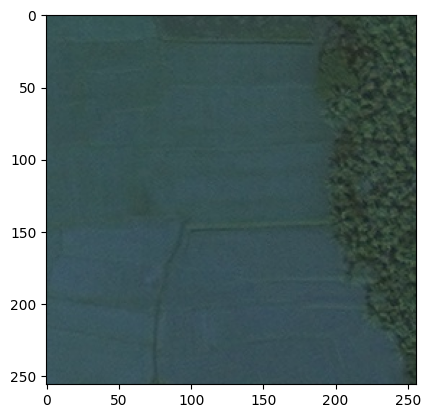

In [4]:
from image_process import image_generator

img_gen = image_generator(IMAGE_DIR)
img = next(img_gen)
print(img.shape)
plt.imshow(img)

(256, 256, 3)


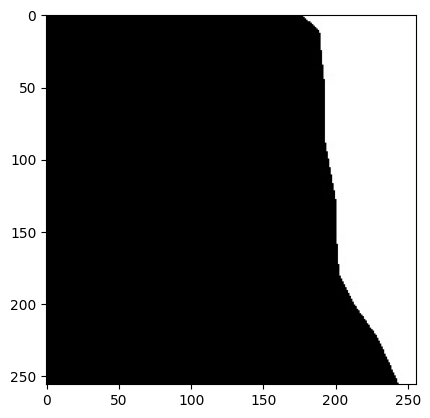

In [5]:
mask_gen = image_generator(MASK_DIR)
mask = next(mask_gen)
print(mask.shape)
plt.imshow(mask)

(256, 256)


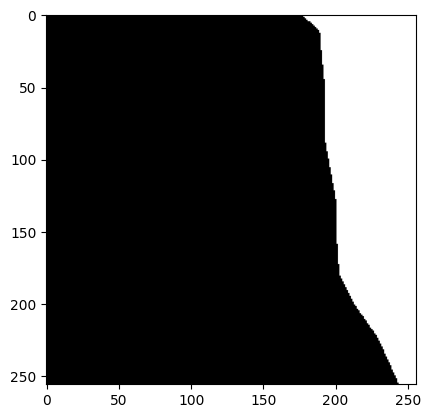

In [6]:
from image_process import rgb2bin
mask_bin = rgb2bin(mask, threshold=IMAGE_THRESHOLD)
print(mask_bin.shape)
plt.imshow(mask_bin, cmap='gray')

In [7]:
IMAGE_SHAPE = img.shape[:2]
IMAGE_SHAPE

(256, 256)

In [8]:
len(df)

5108

## Dataset

In [9]:
from image_process import ForestImageDataset

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

train_dataset = ForestImageDataset(train_df, IMAGE_DIR, MASK_DIR, IMAGE_SHAPE, mode='train')
val_dataset = ForestImageDataset(val_df, IMAGE_DIR, MASK_DIR, IMAGE_SHAPE, mode='val')
test_dataset = ForestImageDataset(test_df, IMAGE_DIR, MASK_DIR, IMAGE_SHAPE, mode='test')

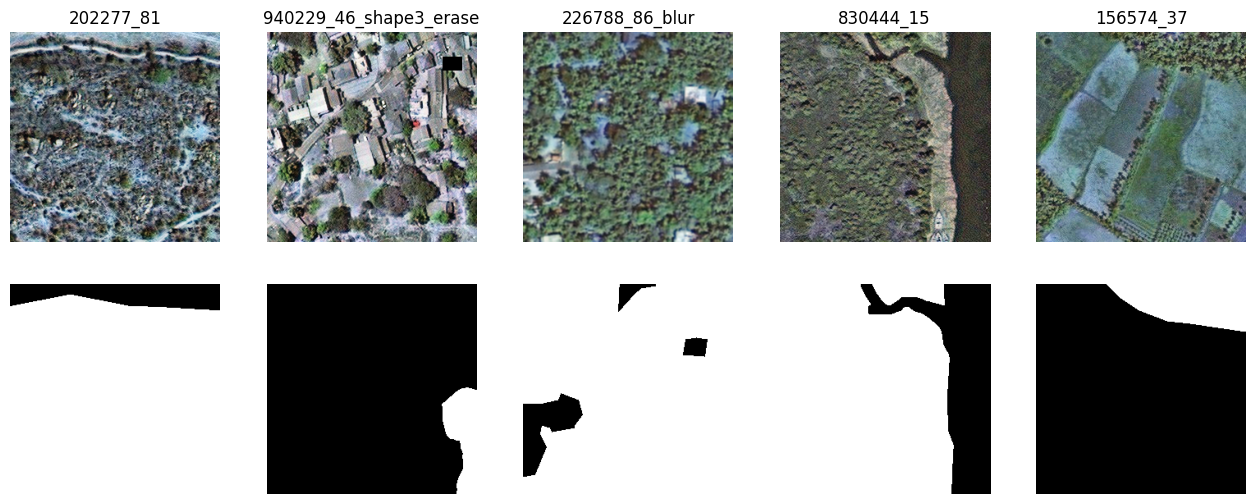

In [10]:
## show the first 5 images of the training dataset
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i in range(5):
    img, mask, tag = train_dataset[i]
    # transform from tensor to numpy array
    img = img.permute(1, 2, 0).numpy()
    mask = mask.permute(1, 2, 0).numpy()
    axes[0][i].imshow(img)
    axes[1][i].imshow(mask.squeeze(), cmap='gray')
    axes[0][i].set_title(tag)
    ## set axis off
    axes[0][i].axis('off')
    axes[1][i].axis('off')
plt.show()


## Train and Validation

In [11]:
BATCH_SIZE = 20
START_EPOCH = 1 # start EarlyStopper tracing from this epoch
MAX_EPOCHS = 10 # max epochs to train

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
from model_unet import UNet
from train_evaluation import train, evaluate, EarlyStopper, TverskyLoss, CombinedBCETverskyLoss

In [13]:
## model
model = UNet(INPUT_CHANNEL, OUTPUT_CHANNEL)
model.to(DEVICE)

## loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = TverskyLoss(alpha=0.4, beta=0.6)

In [14]:
## train and evaluate
early_stopper = EarlyStopper(patience=3, min_delta=0.005, start_epoch=START_EPOCH)

train_losses = []
val_losses = []
val_ious = []
val_accs = []
for epoch in range(1, MAX_EPOCHS+1):
    train_loss = train(model, DEVICE, train_loader, loss_func, optimizer)
    val_loss, val_iou, val_acc = evaluate(model, DEVICE, val_loader, loss_func)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_accs.append(val_acc)
    print(f'Epoch {epoch}: train loss {train_loss:.4f}, val loss {val_loss:.4f}, val IOU {val_iou:.4f}, val acc {val_acc:.4f}')
    saved_epoch = early_stopper.early_stop(val_loss, model) # return False if not early stopping; once True, return the epoch where model is saved
    if saved_epoch:
        print(f'Early stopping at epoch {epoch}')
        print(f'Model saved at epoch {saved_epoch}, with validation loss: {val_losses[saved_epoch]:.2f}, validation IOU: {val_ious[saved_epoch]:.2f}')
        break

Epoch 1: train loss 0.2419, val loss 0.1644, val IOU 0.7166, val acc 0.7644
Epoch 2: train loss 0.1677, val loss 0.1472, val IOU 0.7233, val acc 0.7718
Epoch 3: train loss 0.1555, val loss 0.1608, val IOU 0.7236, val acc 0.7967
Epoch 4: train loss 0.1484, val loss 0.1432, val IOU 0.7341, val acc 0.7946
Epoch 5: train loss 0.1495, val loss 0.2153, val IOU 0.6645, val acc 0.7674
Early stopping at epoch 5
Model saved at epoch 1, with validation loss: 0.15, validation IOU: 0.72


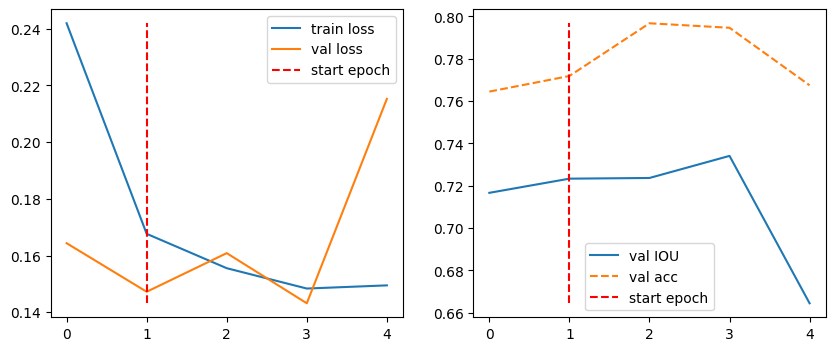

In [15]:
## plot loss and IOU
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(train_losses, label='train loss')
axes[0].plot(val_losses, label='val loss')
losses = np.array(train_losses + val_losses)
max_loss, min_loss = losses.max(), losses.min()
axes[0].plot([START_EPOCH, START_EPOCH], [min_loss, max_loss], 'r--', label='start epoch')
axes[0].legend()

axes[1].plot(val_ious, label='val IOU')
axes[1].plot(val_accs, label='val acc', linestyle='--')
accs = np.array(val_ious + val_accs)
max_acc, min_acc = accs.max(), accs.min()
axes[1].plot([START_EPOCH, START_EPOCH], [min_acc, max_acc], 'r--', label='start epoch')
axes[1].legend()
plt.show()


In [16]:
## test saved model
model.load_state_dict(torch.load(early_stopper.save_path, weights_only=True))
None

In [17]:
best_thresh = 0.5
max_iou = 0.
for i, thresh in enumerate(np.linspace(0.1, 0.9, 17)):
    _, val_iou, pix_acc = evaluate(model, DEVICE, test_loader, loss_func, thresh=thresh, verbose=0, plot=False)
    print(f'Threshold: {thresh:.2f}', end=' | ')
    print(f'Validation iou: {val_iou:.2f}') # , pixel accuracy: {pix_acc:.2f}
    if val_iou > max_iou:
        best_thresh = thresh
        max_iou = val_iou
print(f'Best threshold: {best_thresh:.2f} with iou: {max_iou:.2f}')

Threshold: 0.10 | Validation iou: 0.70
Threshold: 0.15 | Validation iou: 0.70
Threshold: 0.20 | Validation iou: 0.70
Threshold: 0.25 | Validation iou: 0.70
Threshold: 0.30 | Validation iou: 0.70
Threshold: 0.35 | Validation iou: 0.70
Threshold: 0.40 | Validation iou: 0.70
Threshold: 0.45 | Validation iou: 0.70
Threshold: 0.50 | Validation iou: 0.71
Threshold: 0.55 | Validation iou: 0.71
Threshold: 0.60 | Validation iou: 0.71
Threshold: 0.65 | Validation iou: 0.71
Threshold: 0.70 | Validation iou: 0.71
Threshold: 0.75 | Validation iou: 0.71
Threshold: 0.80 | Validation iou: 0.71
Threshold: 0.85 | Validation iou: 0.71
Threshold: 0.90 | Validation iou: 0.71
Best threshold: 0.90 with iou: 0.71


### Baseline

In [18]:
## randomly predict pixels from test dataset
def random_predict(device, val_loader, verbose=0):
    from train_evaluation import iou_accuracy, pixel_accuracy
    # ## generate a torch tensor with random 0 and 1's
    # batch_size = val_loader.batch_size
    # random_mask = torch.randint(0, 2, (batch_size, 1, *image_shape), dtype=torch.float32)

    tot_accuracy = 0.
    tot_pix_acc = 0.
    num_images = len(val_loader)
    for i, (X, Y, tag) in enumerate(val_loader):
        X, Y = X.to(device), Y.to(device)
        ## generate a torch tensor with random 0 and 1's
        random_mask = torch.randint(0, 2, Y.shape, dtype=torch.float32)
        Y_pred = random_mask.to(device)
        
        accuracy = iou_accuracy(Y_pred, Y)
        tot_accuracy += accuracy
        pix_acc = pixel_accuracy(Y_pred, Y)
        tot_pix_acc += pix_acc
        print(f'IOU accuracy: {accuracy:.2f}, pixel accuracy: {pix_acc:.2f}') if verbose else None
    
    avg_accuracy = tot_accuracy / num_images
    avg_pix_acc = tot_pix_acc / num_images
    print(f'Validation loss: {avg_val_loss:.2f}. Validation accuracy (IOU): {avg_accuracy:.2f}, (pixel): {avg_pix_acc:.2f}') if verbose else None
    
    return avg_accuracy, avg_pix_acc

random_iou, _ = random_predict(DEVICE, test_loader)
print(f'Random prediction IOU: {random_iou:.2f}')

Random prediction IOU: 0.38


Our model performs decently with an average IOU of 0.71 which is much better than the baseline IOU 0.38

## Demonstration

In [19]:
_, demonstrate_df = train_test_split(test_df, test_size=10/len(test_df), random_state=26)
demonstrate_df

,image,mask
1412,296279_sat_87.jpg,296279_mask_87.jpg
1703,3484_sat_42.jpg,3484_mask_42.jpg
4448,880610_sat_80.jpg,880610_mask_80.jpg
4476,882451_sat_38.jpg,882451_mask_38.jpg
1859,392711_sat_10.jpg,392711_mask_10.jpg
724,192918_sat_20.jpg,192918_mask_20.jpg
168,122178_sat_03.jpg,122178_mask_03.jpg
3333,725646_sat_02.jpg,725646_mask_02.jpg
996,226788_sat_55.jpg,226788_mask_55.jpg
2127,439854_sat_77.jpg,439854_mask_77.jpg


In [20]:
demonstrate_dataset = ForestImageDataset(demonstrate_df, IMAGE_DIR, MASK_DIR, IMAGE_SHAPE, mode='test')
demonstrate_loader = DataLoader(demonstrate_dataset, batch_size=1, shuffle=False)

Validation for image-('296279_87',), loss: 0.010942935943603516
IOU accuracy: 0.99, pixel accuracy: 0.99
Validation for image-('3484_42',), loss: 0.17214488983154297
IOU accuracy: 0.69, pixel accuracy: 0.73
Validation for image-('880610_80',), loss: 0.778271496295929
IOU accuracy: 0.10, pixel accuracy: 0.84
Validation for image-('882451_38',), loss: 0.03571665287017822
IOU accuracy: 0.93, pixel accuracy: 0.93
Validation for image-('392711_10',), loss: 0.014229178428649902
IOU accuracy: 0.98, pixel accuracy: 0.98
Validation for image-('192918_20',), loss: 0.012536585330963135
IOU accuracy: 0.99, pixel accuracy: 0.99
Validation for image-('122178_03',), loss: 0.021066248416900635
IOU accuracy: 0.97, pixel accuracy: 0.97
Validation for image-('725646_02',), loss: 0.5844337940216064
IOU accuracy: 0.23, pixel accuracy: 0.44
Validation for image-('226788_55',), loss: 0.13421416282653809
IOU accuracy: 0.74, pixel accuracy: 0.75
Validation for image-('439854_77',), loss: 0.4520791172981262
IOU

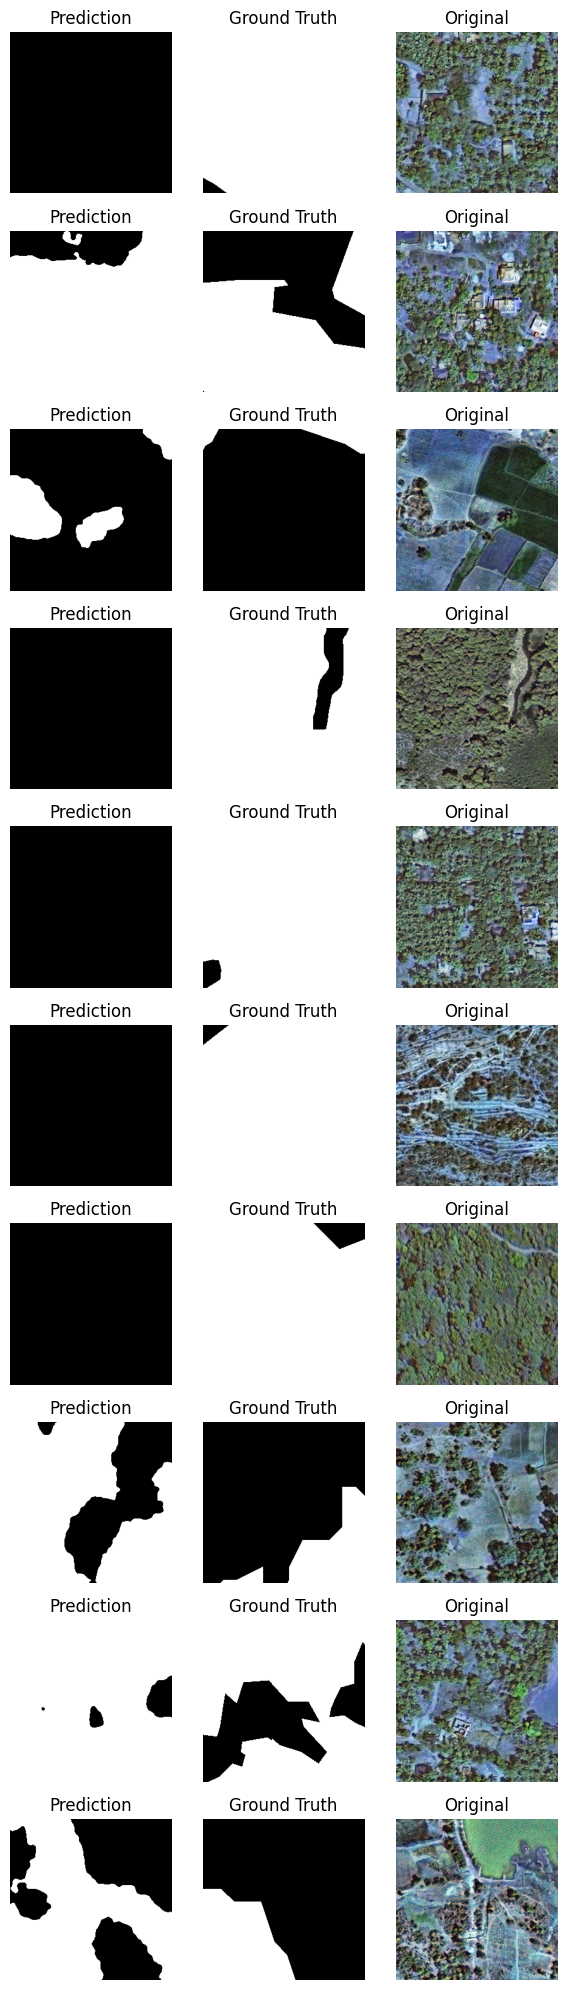

Validation loss: 0.22. Validation accuracy (IOU): 0.70, (pixel): 0.82


In [21]:
evaluate(model, DEVICE, demonstrate_loader, loss_func, thresh=best_thresh, verbose=1, plot=True)
None